In [1]:
from laplace import Laplace
import torch
import torchvision
from torch import nn
import wandb
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from src.semiSub_model import getModel
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)

%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./melanoma_laplace.ipynb

def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


figsize = get_figsize(234*2)
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}
plt.rcParams.update(tex_fonts)


Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./melanoma_laplace.ipynb
Figure size= [3.2378580323785804, 2.00110631475682]


In [4]:
from src.base_models import BaseModel
from src.semiSub_model import SemiAdditive

class SimpleCnnt(BaseModel):
    def __init__(self, output_dim, weight_decay: float = 0., lr: float = 1e-4, seed: int = None, **kwargs):
        super(SimpleCnnt, self).__init__(**kwargs)
        if seed is not None:
            pl.seed_everything(seed)
        # self.save_hyperparameters('num_bends', 'lr', 'seed')
        self.save_hyperparameters('weight_decay', 'lr', 'seed')
        self.conv = nn.Sequential(nn.Conv2d(3, 32, 3, ),  # 128
                                  nn.Tanh(),
                                  nn.MaxPool2d(2, ),  # 126
                                  nn.Conv2d(32, 32, 3),  # 63
                                  nn.Tanh(),
                                  nn.MaxPool2d(2, ),  # 61
                                  nn.Conv2d(32, 64, 3),  # 30
                                  nn.Tanh(),
                                  nn.MaxPool2d(2, ),  # 28
                                  nn.Conv2d(64, 64, 3),  # 14
                                  nn.Tanh(),
                                  nn.MaxPool2d(2, ),  # 12
                                  nn.Conv2d(64, 128, 3),  # 6
                                  nn.Tanh(),
                                  nn.MaxPool2d(2, )  # 4
                                  )
        self.lin = nn.Sequential(nn.Flatten(),  # 2
                                 nn.Linear(2 * 2 * 128, 128),
                                 nn.Tanh(),
                                 nn.Linear(128, 128),
                                 nn.Tanh(),
                                 nn.Linear(128, output_dim)
                                 )
        self.dnn = nn.Sequential(self.conv, self.lin)

    def forward(self, u):
        return self.dnn(u)
    

class SimpleCnnSemi(SemiAdditive, SimpleCnnt):
    def __init__(self, num_structure, output_dim, **kwargs):
        super(SimpleCnnSemi, self).__init__(num_structure=num_structure, output_dim=output_dim, **kwargs)
        self.u_shape = (3,128,128)
        self.x_input_feature = num_structure

    @staticmethod
    def pseudo_inv_softmax(x):
        y1 = -torch.log(x[...,1:])
        y2 = -torch.log(x[...,0:1])
        return torch.hstack([y1,y2])
    
    def forward(self, data) -> torch.Tensor:
        x = data[:,-self.x_input_feature:]
        u = data[:,:-self.x_input_feature].reshape(-1,*self.u_shape)
        logit_1 = super().forward(u, x)
        p1 = torch.sigmoid(logit_1) # p(y=1|x,u)
        pseudo_logits = self.pseudo_inv_softmax(torch.hstack([1-p1, p1]))
        return pseudo_logits
        
    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        data, y = train_batch
        if y.device != self.device:
            y = y.to(device=self.device)
            data = data.to(device=self.device)
        eta_prime = self(data)
        loss = self.loss_fn(eta_prime, y)
        self.log('train/loss', loss, on_step=True, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx) -> dict:
        data, y = batch
        eta_prime = self(data)
        loss = self.loss_fn(eta_prime, y)
        self.log('valid/loss', loss, on_step=False, on_epoch=True, sync_dist=True)
        self.valid_metrics(eta_prime, y)
        self.log_dict(self.valid_metrics, on_step=False, on_epoch=True)
        return eta_prime.detach()

    def test_step(self, batch, batch_idx) -> dict:
        data, y = batch
        eta_prime = self(data)
        loss = self.loss_fn(eta_prime, y)
        self.log('test/loss', loss, on_step=False, on_epoch=True, sync_dist=True)
        self.test_metrics(eta_prime, y)
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)
        return eta_prime.detach()
SimpleCnnSemi(1,2, loss_fn=torch.nn.CrossEntropyLoss())

SemiAdditive


SimpleCnnSemi(
  (loss_fn): CrossEntropyLoss()
  (valid_metrics): MetricCollection(
    (BinaryCalibrationError): BinaryCalibrationError()
    (BinaryAUROC): BinaryAUROC()
    (BinaryAccuracy): BinaryAccuracy()
    (BinaryAveragePrecision): BinaryAveragePrecision()
    (BinaryF1Score): BinaryF1Score(),
    prefix=valid/
  )
  (test_metrics): MetricCollection(
    (BinaryCalibrationError): BinaryCalibrationError()
    (BinaryAUROC): BinaryAUROC()
    (BinaryAccuracy): BinaryAccuracy()
    (BinaryAveragePrecision): BinaryAveragePrecision()
    (BinaryF1Score): BinaryF1Score(),
    prefix=test/
  )
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))

# Train initial model
- Using corssentropy loss because Laplace framework requires this classification loss
- Same CNN as in our subspace exp used
- changed one-dimensional output $\eta$ into $\eta' = \text{inv}_{\text{softmax}}\left(\begin{bmatrix} \sigma(\eta) \\ 1 - \sigma(\eta) \end{bmatrix}\right)$


In [ ]:
from src.plot import exclude_project_code_dirs
from utils_datamodel.pl_utils import MelanomDataModuleFromSplit
from torchmetrics import MetricCollection, CalibrationError, AUROC, Accuracy, AveragePrecision, F1Score
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from utils_datamodel.utils import FastFillTensorDataLoader

wandb_logger = WandbLogger(project='laplace_melanoma', log_model=False, name='laplace',
                            group="SimpleCnn", resume='never')
# define a metric we are interested in the best of
wandb_logger.experiment.define_metric("valid/loss", summary="min")
wandb_logger.experiment.define_metric("valid/CalibrationError", summary="min")
wandb_logger.experiment.define_metric("valid/AUROC", summary="max")
wandb_logger.experiment.define_metric("valid/Accuracy", summary="max")
wandb_logger.experiment.define_metric("valid/AveragePrecision", summary="max")
wandb_logger.experiment.define_metric("valid/F1Score", summary="max")
# wandb_logger.experiment.define_metric("test/loss", summary="min")
# wandb_logger.experiment.define_metric("test/AUROC", summary="max")



def target_trans(y):
    return torch.tensor(y).to(dtype=torch.long)
transform = nn.Sequential(torchvision.transforms.ConvertImageDtype(torch.float32),
                            torchvision.transforms.Normalize((0.8061, 0.6210, 0.5914), (0.1484, 0.1748, 0.1999)))
transform = torch.jit.trace(transform, torch.randint(0, 255, (3, 128, 128), dtype=torch.uint8))
dm = MelanomDataModuleFromSplit(wandb_logger=wandb_logger,
                                split=1,
                                batch_size=256,
                                reuse_artifact=True,
                                meta_features=['age_approx'],
                                transform_test=transform,
                                transform_train=transform,
                                target_transform=target_trans)
dm.prepare_data()
dm.setup()
# preload data
u, x, y = [], [], []
for (uu, xx), yy in dm.train_dataloader():
    u.append(uu)
    x.append(xx)
    y.append(yy)
u = torch.vstack(u) # .to(device=device)
x = torch.vstack(x) # .to(device=device)
y = torch.hstack(y) # .to(device=device)
data = torch.cat([u.reshape(u.shape[0],-1), x], dim=1)
dataset = torch.utils.data.TensorDataset(data,y)
train_loader = FastFillTensorDataLoader(dataset, batch_size=256, shuffle=True, pin_memory=False)

u, x, y = [], [], []
for (uu, xx), yy in dm.val_dataloader():
    u.append(uu)
    x.append(xx)
    y.append(yy)
u = torch.vstack(u).to(device=device)
x = torch.vstack(x).to(device=device)
y = torch.hstack(y).to(device=device)
data = torch.cat([u.reshape(u.shape[0],-1), x], dim=1)
dataset = torch.utils.data.TensorDataset(data,y)
valid_cuda_loader = FastFillTensorDataLoader(dataset, batch_size=len(dataset)//10, shuffle=False, pin_memory=False)

u, x, y = [], [], []
for (uu, xx), yy in dm.test_dataloader():
    u.append(uu)
    x.append(xx)
    y.append(yy)
u = torch.vstack(u) # .to(device=device)
x = torch.vstack(x) # .to(device=device)
y = torch.hstack(y) # .to(device=device)
data = torch.cat([u.reshape(u.shape[0],-1), x], dim=1)
dataset = torch.utils.data.TensorDataset(data,y)
test_loader = FastFillTensorDataLoader(dataset, batch_size=len(dataset)//10, shuffle=False, pin_memory=False)

model = SimpleCnnSemi(seed=10, weight_decay=1e-4, lr=5e-3, num_structure=1, output_dim=1,
                  loss_fn=torch.nn.CrossEntropyLoss(reduction='mean'),
                  metric_collection=MetricCollection([CalibrationError(task="multiclass", num_classes=2),
                                                     AUROC(task="multiclass", num_classes=2),
                                                     Accuracy(task="multiclass", num_classes=2),
                                                     AveragePrecision(task="multiclass", num_classes=2),
                                                     F1Score(task="multiclass", num_classes=2, threshold=0.1)
                                                     ]))
ckp_dir = os.path.join(wandb_logger.experiment.dir, "checkpoints")
callbacks = [ModelCheckpoint(dirpath=ckp_dir, save_top_k=1, monitor="valid/loss")]
trainer = pl.Trainer(max_epochs=100,
                     logger=wandb_logger,
                     callbacks=callbacks)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_cuda_loader)
best_model = type(model).load_from_checkpoint(checkpoint_path=callbacks[0].best_model_path)
trainer.test(best_model, dataloaders=test_loader)

wandb_logger.experiment.log_code("./", name=f"project_code_{wandb_logger.experiment.id}", exclude_fn=exclude_project_code_dirs) # exclude drbayes, wandb, dnn-mode-connectivity
# save model as artifact
art = wandb.Artifact(f"model_state_{wandb_logger.experiment.id}", type=model.__class__.__name__, description="Simple CNN Model")
art.add_dir(ckp_dir)
wandb_logger.experiment.log_artifact(art)

In [ ]:
print("Theta: ", model.structure_lin.weight)
print("Bias: ", model.dnn[1][-1].bias)

Theta:  Parameter containing:
tensor([[0.5665]], requires_grad=True)
Bias:  Parameter containing:
tensor([-3.5606], requires_grad=True)


# Fit Laplace approximation on last layer and theta parameters

In [ ]:
from laplace.utils import ModuleNameSubnetMask
subnetwork_mask = ModuleNameSubnetMask(best_model, module_names=['structure_lin', 'lin.5'])
subnetwork_mask.select()
subnetwork_indices = subnetwork_mask.indices


# Define and fit subnetwork LA using the specified subnetwork indices
la = Laplace(best_model.to(device=device), 'classification',
             subset_of_weights='subnetwork',
             hessian_structure='full',
             subnetwork_indices=subnetwork_indices)
la.fit(train_loader)

In [9]:
print(best_model.structure_lin.weight)

Parameter containing:
tensor([[0.5475]], device='cuda:0', requires_grad=True)


(array([  1.,   0.,   0.,   0.,   1.,   5.,   9.,   5.,  23.,  27.,  44.,
         44.,  64.,  73., 107., 109., 109., 100.,  86.,  71.,  44.,  23.,
         27.,  17.,   4.,   2.,   3.,   1.,   0.,   1.]),
 array([0.33156297, 0.34539825, 0.35923356, 0.37306887, 0.38690415,
        0.40073943, 0.41457474, 0.42841005, 0.44224533, 0.45608062,
        0.46991593, 0.48375124, 0.49758652, 0.5114218 , 0.52525711,
        0.53909242, 0.55292773, 0.56676298, 0.58059829, 0.59443361,
        0.60826886, 0.62210417, 0.63593948, 0.64977479, 0.6636101 ,
        0.67744535, 0.69128066, 0.70511597, 0.71895123, 0.73278654,
        0.74662185]),
 <BarContainer object of 30 artists>)

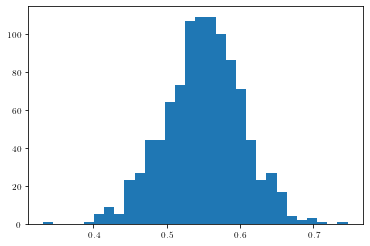

In [10]:
subnetwork_mask_struct = ModuleNameSubnetMask(best_model, module_names=['structure_lin'])
subnetwork_mask_struct.select()
subnetwork_mask_struct.indices
structure_samples = la.sample(1000)[:, subnetwork_mask_struct.indices]
from matplotlib import pyplot as plt
plt.hist(structure_samples.detach().cpu().numpy(), bins=30)

In [11]:
structure_samples.mean(0)

tensor([0.5499], device='cuda:0')

In [13]:
structure_samples = la.sample(1000)[:, subnetwork_mask_struct.indices]
theta_age = structure_samples[:,0] 
coords = {'theta_dim_0': [0,],'theta_dim_1':[0,]}
dims = {"theta":['theta_dim_0', 'theta_dim_1']}
data = {'theta':theta_age.detach().cpu().numpy()[None,:,None,None]}
post_laplace_theta = az.convert_to_inference_data(data, coords=coords, dims=dims)
post_laplace_theta.to_netcdf("post_laplace_theta.nc")

post_laplace_all = az.convert_to_inference_data(la.sample(100).detach().cpu().numpy()[None,...])
post_laplace_all.to_netcdf("post_laplace_all.nc")

art = wandb.Artifact(f"data_{wandb_logger.experiment.id}", type="xarray",
                        description="posterior from laplace model")
art.add_file("post_laplace_theta.nc")
art.add_file("post_laplace_all.nc")
wandb_logger.experiment.log_artifact(art)
# az.convert_to_inference_data(theta_age.detach().cpu().numpy(), )

<Artifact data_us583dgg>

In [14]:
post_laplace_theta

Inference data with groups:
	> posterior

# compute lppd

In [22]:
import numpy as np
# compute predictive performance
preds = []
obs = []
for data, y_valid in valid_cuda_loader:
    pred = la.predictive_samples(data, pred_type='nn', n_samples=100)
    preds.append(pred)
    obs.append(y_valid)
preds = torch.concatenate(preds, dim=1) # shape: (#samples,#data,#params)
obs = torch.concatenate(obs, dim=-1)
prob = torch.gather(preds, dim=2, index=obs[None,:,None].tile(preds.shape[0], 1,1))
log_like = torch.log(prob.squeeze())
lppd_valid = (torch.logsumexp(log_like, dim=0) - np.log(preds.shape[0])).sum()
wandb_logger.experiment.summary["valid_lppd"] = lppd_valid
lppd_valid

tensor(-477.9789, device='cuda:0')

In [24]:
import numpy as np
# compute predictive performance
preds = []
obs = []
for data, y_valid in test_loader:
    pred = la.predictive_samples(data, pred_type='nn', n_samples=20)
    preds.append(pred)
    obs.append(y_valid)
preds = torch.concatenate(preds, dim=1) # shape: (#samples,#data,#params)
obs = torch.concatenate(obs, dim=-1).to(device=device)
prob = torch.gather(preds, dim=2, index=obs[None,:,None].tile(preds.shape[0], 1,1))
log_like = torch.log(prob.squeeze())
lppd_test = (torch.logsumexp(log_like, dim=0) - np.log(preds.shape[0])).sum()
wandb_logger.experiment.summary["test_lppd"] = lppd_test
lppd_test

tensor(-506.4347, device='cuda:0')

In [25]:
auroc = [AUROC(task="multiclass", num_classes=2)(pred, obs).cpu().numpy() for pred in preds]
np.mean(auroc)

0.78053266

In [27]:
np.std(auroc)

0.0043251133

In [28]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test/MulticlassAUROC,▁
test/MulticlassAccuracy,▁
test/MulticlassAveragePrecision,▁
test/MulticlassCalibrationError,▁
test/MulticlassF1Score,▁
test/loss,▁
train/loss_epoch,█▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid/MulticlassAUROC,▁▆▇▇▇█▇█▅▅▆█▇▇█▇▇▇▇▇▇▇█████▇███▇▇▇▇▆▇▇██
